In [8]:
import numpy as np 
import pickle 
import h5py
from scipy import stats
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd
from pathlib import Path
import re


%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import src.util_analysis as util_analysis

In [23]:
# So that we can edit the text in illustrator
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
fig_out_dir = Path("rebuttal_figs/")
fig_out_dir.mkdir(parents=True, exist_ok=True)




In [10]:
analysis_dir = Path(f"/om/scratch/Thu/imgriff/binaural_unit_activation_analysis/")
all_models = list(analysis_dir.glob("*v10*"))
models_to_run = []

for path in all_models:
    if not path.is_dir():
        continue

    if 'control' in path.stem:
        continue

    models_to_run.append(path)


model_name_dict = {path.stem: util_analysis.get_model_name(path.stem) for path in models_to_run}


def sort_layers(layers):
    # Separate layers into categories
    coch_layers = ['cochleagram', 'norm_coch_rep']
    fc_layers = ['attnfc', 'relufc']
    n_blocks = len([layer for layer in layers if ('relu' in layer and 'fc' not in layer)])

    block_order = []
    for block_ix in range(n_blocks):
        block_order.append(f'attn{block_ix}')
        block_order.append(f'conv{block_ix}_ln')
        block_order.append(f'conv{block_ix}_relu')
        block_order.append(f'hann_pool_{block_ix}')

    # Combine all categories in the desired order
    return coch_layers + block_order + fc_layers


import scipy
vec_pearsonr = np.vectorize(scipy.stats.pearsonr,
                signature='(n),(n)->(),()')

In [ ]:

## hide future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

h5_fn = analysis_dir/'word_task_v10_main_feature_gain_config_latest_ckpt/word_task_v10_main_feature_gain_config_latest_ckpt_model_activations_0dB_cue_single_source_as_fn_of_sep.h5'


# for path in paths:
distractor_conditions = ['same_sex_talker', 'diff_sex_talker',  'natural_scene']


dfs = []

for model_dir in models_to_run:
    h5_fn = model_dir / f"{model_dir.stem}_model_activations_0dB_cue_single_source_as_fn_of_sep.h5"

    try:
        with h5py.File(h5_fn, 'r', swmr=True) as acts:
            ## Get keys with corr in them 
            all_act_keys = list(acts.keys())
            layer_names = set([l.split('_target')[0].replace('_cued', '') for l in acts.keys() if 'target' in l and not  any([str_part in l for str_part in ['_f0', '_loc', '_word']])]) # set to remove duplicates 
            for layer in layer_names:
                for dist_cond in distractor_conditions:
                    data_dict = {}
                    if dist_cond == 'same_sex_talker':
                        fg_corr_key = f"{layer}_cued_target_mixture_same_corr"
                        bg_corr_key = f"{layer}_cued_same_sex_dist_mixture_same_corr"
                    elif dist_cond == 'diff_sex_talker':
                        fg_corr_key = f"{layer}_cued_target_mixture_diff_corr"
                        bg_corr_key = f"{layer}_cued_diff_sex_dist_mixture_diff_corr"
                    elif dist_cond == 'natural_scene':
                        continue
   
                    if layer == 'cochleagram':
                        bg_corr_key = bg_corr_key.replace('sex_', '')      
                        fg_corr_key = fg_corr_key.replace('cued_', '')
                        bg_corr_key = bg_corr_key.replace('cued_', '')

                    data_dict['fg_corrs'] = acts[fg_corr_key][:,0]
                    data_dict['bg_corrs'] = acts[bg_corr_key][:,0]
                    data_dict['target_azim'],  data_dict['target_elev'] = zip(*acts['target_loc'][:])
                    data_dict['dist_azim'], data_dict['dist_elev'] = zip(*acts['distractor_loc'][:])
                    N_examples = len(data_dict['fg_corrs'])

                    data_dict['layer'] = [layer] * N_examples
                    data_dict['distractor_condition'] = [dist_cond] * N_examples

                    df = pd.DataFrame(data_dict)
                    df['model_name'] = model_name_dict[h5_fn.parent.name]
                    df['group'] = 'random weights' if 'rand' in h5_fn.parent.name else 'feature-gain'
                    dfs.append(df)
    except Exception as e:
        print(f"Error with {h5_fn}")
        print(e)
        # raise

def get_spatial_cond_str(cond_str):
    return f'{int(cond_str)*2}° sep.'

act_results  = pd.concat(dfs, ignore_index=True)
act_results['spatial_cond'] = act_results['target_azim'].apply( get_spatial_cond_str)
act_results['layer'] = act_results['layer'].str.replace('_block_', '')

act_results['log_corr_ratio'] = np.log(np.sqrt(act_results['fg_corrs']**2 / act_results['bg_corrs']**2))

act_corrs = pd.melt(act_results[[col for col in act_results.columns if 'cos' not in col]], id_vars =['layer', 'group', 'distractor_condition', 'model_name', 'spatial_cond'], value_vars=['fg_corrs', 'bg_corrs'], var_name='Stream',
                            value_name="Pearson's r")


act_corrs['Stream'].replace('fg_corrs','corr(target$_i$, mixture$_i$)',inplace=True)
act_corrs['Stream'].replace('bg_corrs','corr(distractor$_i$, mixture$_i$)',inplace=True)

act_corrs['distractor_condition'].replace('same_sex_talker','Same sex',inplace=True)
act_corrs['distractor_condition'].replace('diff_sex_talker','Different sex',inplace=True)

        

In [16]:
act_corrs.group.value_counts()

group
random weights    786000
feature-gain      786000
Name: count, dtype: int64

In [18]:
import re
# Get layer order per model. Will have from [cochleagram, norm_coch_rep, ..., attnfc, relufc]
layer_order_dict = {}

def get_int(val):
    return int(re.search(r'\d+', val).group())

for model in act_results['model_name'].unique():
    layers = act_results.loc[act_results['model_name'] == model, 'layer'].unique()
    sorted_layers = sort_layers(layers)
    for layer in sorted_layers:
        if (model == "Computed-gain model" or 'Backbone' in model) and 'attn' in layer:
            sorted_layers.remove(layer)
        if model == 'Late-only':
            if 'attn' in layer and layer != 'attnfc':
                sorted_layers.remove(layer)
        elif model == 'Early-only':
            if 'attn' in layer:
                layer_int = len(layers) if 'fc' in layer else get_int(layer)
                if layer_int > 0:
                    sorted_layers.remove(layer)
    layer_order_dict[model] = sorted_layers


# Main figure



In [19]:
df_for_agg = act_corrs[act_corrs.model_name.str.contains('main|alt') & ~act_corrs.distractor_condition.str.contains('Natural')].copy()
df_for_agg = df_for_agg.groupby(['model_name', 'group', 'layer', 'spatial_cond', 'Stream']).agg({'Pearson\'s r': ['mean', 'sem']}).reset_index()
df_for_agg.columns = ['model_name', 'group', 'layer', 'spatial_cond', 'Stream', 'r', 'r_sem']
df_for_agg = df_for_agg[df_for_agg.layer.str.contains('cochlea|relu')].reset_index(drop=True)

In [20]:
df_for_agg.Stream = df_for_agg['Stream'].str.replace('r_tgt_mixture', 'corr(target$_i$, mixture$_i$)')
df_for_agg.Stream = df_for_agg['Stream'].str.replace('r_dist_mixture', 'corr(distractor$_i$, mixture$_i$)')
# df_for_agg

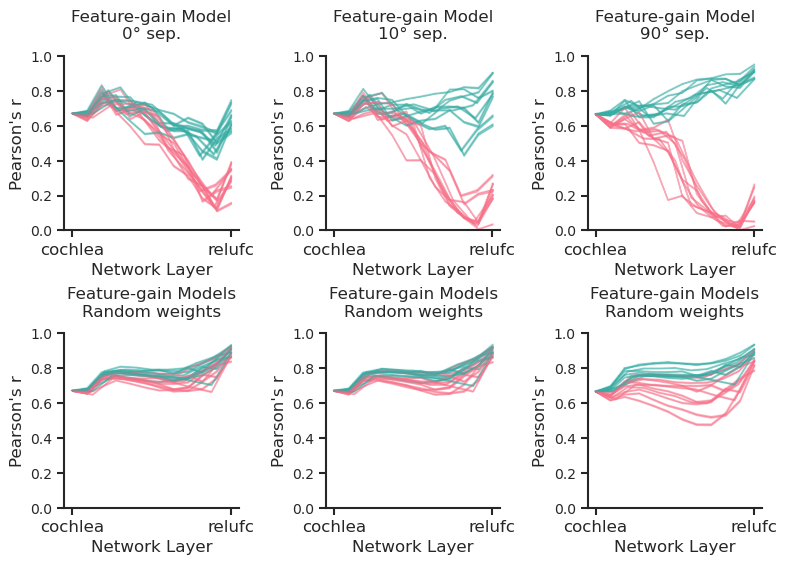

In [ ]:
## Plot summary_results df 
sns.set_style('ticks')

# act_corrs
df_for_agg.Stream.rename({'r_tgt_mixture': 'corr(target$_i$, mixture$_i$)', 'r_dist_mixture': 'corr(distractor$_i$, mixture$_i$)'}, inplace=True)

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
# col_wrap = 6

models = df_for_agg.model_name.unique()
n_models = len(models)


tgt_locs = df_for_agg.spatial_cond.unique()
n_cols = len(tgt_locs) # trained + rand 
n_rows = 2 # int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=12
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
# axs = axs.flatten()


for i, model in enumerate(models):
    row_ix = 1 if 'rand' in model else 0 
    model_df = df_for_agg[df_for_agg['model_name'] == model]
    for axs_ix, loc in enumerate(tgt_locs):
        model_for_panel = model_df[model_df['spatial_cond'] == loc].set_index('layer')
        layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
        try:
            model_for_panel = model_for_panel.loc[layers].reset_index()
            x_axis = np.linspace(0, 1, len(layers))
            for stream in model_for_panel.Stream.unique():
                stream_data = model_for_panel[model_for_panel['Stream'] == stream]
                axs[row_ix, axs_ix].errorbar(x_axis, stream_data['r'], yerr=stream_data['r_sem'], label=stream if axs_ix == 0 else None, alpha=0.1, color=palette_dict[stream])
                axs[row_ix, axs_ix].fill_between(x_axis, stream_data['r'] - stream_data['r_sem'], stream_data['r'] + stream_data['r_sem'], alpha=0.5, color=palette_dict[stream])
        except Exception as e:
            print(f"Error with {model}")
            print(e)
            continue
        if i == 0 :
            axs[0, axs_ix].set_title(f"Feature-gain Model\n{loc}", size=fontsize, y=1.05)
            axs[1, axs_ix].set_title("Feature-gain Models\nRandom weights", size=fontsize, y=1.05)

# make panels square 
# for ax in axs:
for ax in axs.ravel():
    ax.set_aspect('auto')
    ax.set_box_aspect(1)
    ax.set_ylim(0, 1)
    # ax.set_xlim(-0.5, len(layers) - 0.5)
    ax.set_xticks([0,1])
    ax.set_xticklabels(labels=['cochlea', 'relufc'], rotation=0, size=fontsize, )
    ax.set(ylim=(0,1))
    ax.set_xlabel("Network Layer", size=fontsize)
    ax.set_ylabel("Pearson's r", size=fontsize)
    # remove spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    ax.tick_params(axis='both', which='major', length=5, width=1.5)


# remove legend, and instead plot as colored text 
top_y_loc = .175
x_coord = -0.025

sns.despine()

# adjust spacing
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# plt.savefig(fig_out_dir / "figure_5_all_arch_traces_three_azims.pdf", transparent=True, bbox_inches='tight')

